In [1]:
import os

In [2]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection\\Pretrained Models\\ResNet50V2'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt


In [15]:
# Base directory where both Stone and Non-Stone folders are located
BASE_DIR = "artifacts/data_ingestion/Combined_Training_Data"


# Model path (from prepare_model notebook)
MODEL_PATH = "Pretrained Models/Resnet50V2/resnet50v2_kidney_stone_model.h5"
SAVE_BEST_MODEL_PATH = "Pretrained Models/Resnet50V2/resnet_model_updated.h5"

# Hyperparameters
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 30


In [16]:
# Create image generators with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training generator
train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 31058 images belonging to 2 classes.
Found 7763 images belonging to 2 classes.


In [17]:
# Load pre-built model
model = load_model(MODEL_PATH)

# Callbacks
checkpoint_cb = ModelCheckpoint(SAVE_BEST_MODEL_PATH, save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [18]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/30
971/971 [==============================] - 1376s 1s/step - loss: 0.6201 - accuracy: 0.6599 - val_loss: 0.6110 - val_accuracy: 0.6544
Epoch 2/30
971/971 [==============================] - 1379s 1s/step - loss: 0.5362 - accuracy: 0.7322 - val_loss: 0.5654 - val_accuracy: 0.6830
Epoch 3/30
971/971 [==============================] - 1383s 1s/step - loss: 0.5026 - accuracy: 0.7555 - val_loss: 0.5771 - val_accuracy: 0.6737
Epoch 4/30
971/971 [==============================] - 1376s 1s/step - loss: 0.4812 - accuracy: 0.7711 - val_loss: 0.5879 - val_accuracy: 0.6689
Epoch 5/30
971/971 [==============================] - 1389s 1s/step - loss: 0.4660 - accuracy: 0.7787 - val_loss: 0.5644 - val_accuracy: 0.6885
Epoch 6/30
971/971 [==============================] - 1410s 1s/step - loss: 0.4530 - accuracy: 0.7865 - val_loss: 0.5521 - val_accuracy: 0.6867
Epoch 7/30
971/971 [==============================] - 1419s 1s/step - loss: 0.4423 - accuracy: 0.7952 - val_loss: 0.5347 - val_accuracy:

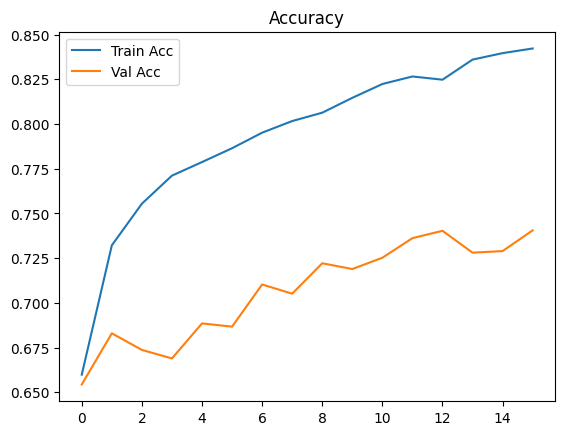

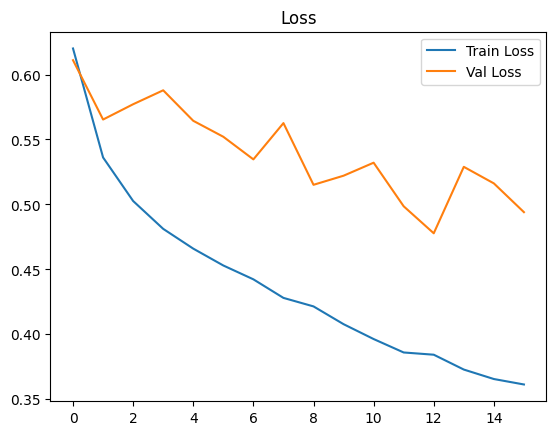

In [19]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()
